In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, LSTM, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
import os
import datetime

In [3]:
%load_ext tensorboard

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [5]:
df = pd.read_csv('airline-passengers.csv', sep = ';')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [6]:
df.index = df['Month']
df.drop(['Month'],axis=1,inplace = True)
df

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


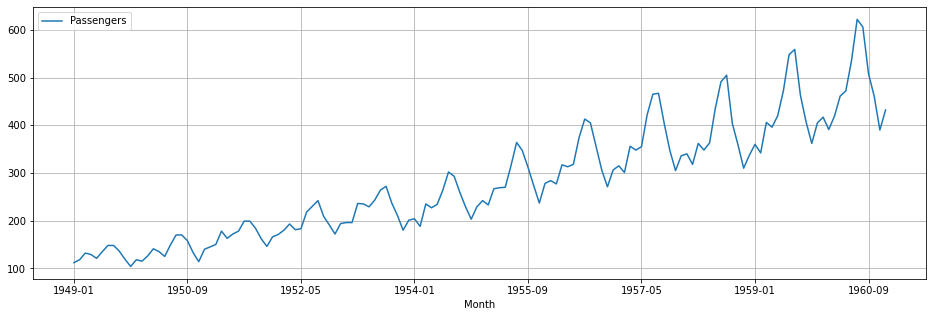

In [7]:
df.plot( figsize = (16,5))
#df['PJME_MW'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [8]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df['data'] = pd.to_datetime(df.index)
df

,Passengers,data
Month,,
1949-01,112,1949-01-01
1949-02,118,1949-02-01
1949-03,132,1949-03-01
1949-04,129,1949-04-01
1949-05,121,1949-05-01
...,...,...
1960-08,606,1960-08-01
1960-09,508,1960-09-01
1960-10,461,1960-10-01


In [10]:
df['month'] = df['data'].dt.month
df

,Passengers,data,month
Month,,,
1949-01,112,1949-01-01,1
1949-02,118,1949-02-01,2
1949-03,132,1949-03-01,3
1949-04,129,1949-04-01,4
1949-05,121,1949-05-01,5
...,...,...,...
1960-08,606,1960-08-01,8
1960-09,508,1960-09-01,9
1960-10,461,1960-10-01,10


In [11]:
df['season'] = 0
df.loc[df.month.isin([1,2,12]), 'season'] = 0
df.loc[df.month.isin([3,4,5]), 'season'] = 1
df.loc[df.month.isin([6,7,8]), 'season'] = 2
df.loc[df.month.isin([9,10,11]), 'season'] = 3
df[['Passengers', 'month', 'season']]



,Passengers,month,season
Month,,,
1949-01,112,1,0
1949-02,118,2,0
1949-03,132,3,1
1949-04,129,4,1
1949-05,121,5,1
...,...,...,...
1960-08,606,8,2
1960-09,508,9,3
1960-10,461,10,3


In [12]:
df.describe()

,Passengers,month,season
count,144.000000,144.000000,144.000000
mean,280.298611,6.500000,1.500000
std,119.966317,3.464102,1.121936
min,104.000000,1.000000,0.000000
25%,180.000000,3.750000,0.750000
50%,265.500000,6.500000,1.500000
75%,360.500000,9.250000,2.250000
max,622.000000,12.000000,3.000000


In [13]:
scaler = StandardScaler()
#print(scaler)
df_norm = df.copy()
#df['Passengers', 'month', 'season']
df_norm[['Passengers', 'month', 'season']] = scaler.fit_transform(df[['Passengers', 'month', 'season']])
df_norm

,Passengers,data,month,season
Month,,,,
1949-01,-1.407779,1949-01-01,-1.593255,-1.341641
1949-02,-1.357590,1949-02-01,-1.303572,-1.341641
1949-03,-1.240483,1949-03-01,-1.013890,-0.447214
1949-04,-1.265578,1949-04-01,-0.724207,-0.447214
1949-05,-1.332496,1949-05-01,-0.434524,-0.447214
...,...,...,...,...
1960-08,2.724417,1960-08-01,0.434524,0.447214
1960-09,1.904669,1960-09-01,0.724207,1.341641
1960-10,1.511525,1960-10-01,1.013890,1.341641


In [14]:
df

,Passengers,data,month,season
Month,,,,
1949-01,112,1949-01-01,1,0
1949-02,118,1949-02-01,2,0
1949-03,132,1949-03-01,3,1
1949-04,129,1949-04-01,4,1
1949-05,121,1949-05-01,5,1
...,...,...,...,...
1960-08,606,1960-08-01,8,2
1960-09,508,1960-09-01,9,3
1960-10,461,1960-10-01,10,3


In [15]:
# список признаков, по которым будем учить
#channelIndexes = [0,1, 2, 3] # BRENT
channelIndexes = [0, 1, 2, 3]

# длина теста
valLen = 100
# длина истории для работы
xLen = 30
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]


NameError: name 'data_f' is not defined